# Fetal Health Classification Project
https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification<br>
One of the main health goals of organizations such as the UN is reducing child and maternal mortality. A majority of these deaths took place in low resource settings and could have been prevented. Cardiotocograms (CTGs) are an inexpesnive way to gauge the health of a fetus and allow early intervention by doctors to prevent child and maternal mortality. The dataset contains features from 2126 CTG exams classified by obstetritians as being normal, suspect, or pathological. The goal of this project is to train a multi-class supervised classification model to be able to accurately classify a CTG exam into one of the three classes.<br>
# Feature Documentation
1: baseline value - Baseline Fetal Heart Rate (FHR) <br>
2: accelerations - Number of accelerations per second <br>
3: fetal_movement - Number of fetal movements per second <br>
4: uterine_contractions - Number of uterine contractions per second <br>
5: light_decelerations - Number of LDs per second <br>
6: severe_decelerations - Number of SDs per second <br>
7: prolongued_decelerations - Number of PDs per second <br>
8: abnormal_short_term_variability - Percentage of time with abnormal short term variability <br>
9: mean_value_of_short_term_variability - Mean value of short term variability <br>
10: percentage_of_time_with_abnormal_long_term_variability - Percentage of time with abnormal long term variability <br>
11: mean_value_of_long_term_variability - Mean value of long term variability <br>
12: histogram_width - Width of the histogram made using all values from a record <br>
13: histogram_min - Histogram minimum value <br>
14: histogram_max - Histogram maximum value <br>
15: histogram_number_of_peaks - Number of peaks in the exam histogram <br>
16: histogram_number_of_zeroes - Number of zeros in the exam histogram <br>
17: histogram_mode - hist mode <br>
18: histogram_mean - hist mean <br>
19: histogram_median - hist median <br>
20: histogram_variance - hist variance <br>
21: histogram_tendency - histogram trend <br>
22: fetal_health
- 1: Normal
- 2: Suspect
- 3: Pathological

# Data Loading and Initial Look

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np 
from IPython.display import HTML, display
import tabulate
%matplotlib inline

In [2]:
# Load and view the dataset
df = pd.read_csv("fetal_health.csv")
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [3]:
# View the size of the dataset
print(df.shape[0], "datapoints and", df.shape[1], "features")

2126 datapoints and 22 features


In [4]:
# Check for missing values
df.isnull().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

Now, let's create a table summarizing information about the features. Most of the features are numerical, except for histogram_tendency and fetal_health. The former records the direction of the histogram trend and the latter is the class label, so we'll make sure to mark them down as categorical before creating the table. 

In [5]:
# Convert the features to categorical
df['histogram_tendency'] = df['histogram_tendency'].astype(str)
df['fetal_health']= df['fetal_health'].astype(str)

# Check to see if it worked
print(df['histogram_tendency'].dtypes)
print(df['fetal_health'].dtypes)

object
object


In [6]:
# Determine feature data type
def feature_type(column):
    if column.dtype == "object":
        return "Categorical"
    else:
        return "Numerical"
    
# Calculate range of values for numerical columns
def calc_range(column):
    return (column.min(), column.max())

# Determine the number of outliers based on IQR
def find_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    
    return len(outliers)

# Create summary table
def summary_table(df):
    summary = []

    for column in df.columns:
        
        data_type = feature_type(df[column])

        if data_type == "Categorical":
            values = df[column].unique()
            outliers = "N/A"
        else:
            values = calc_range(df[column])
            outliers = find_outliers(df[column])

        summary.append({
            "Feature Name": column,
            "Feature Type": data_type,
            "Value Range": values,
            "Number of Missing Values": df[column].isnull().sum(),
            "Number of Outliers": outliers
        })
        
    display(HTML(tabulate.tabulate(summary, tablefmt='html', headers='keys')))

In [7]:
summary_table(df)

Feature Name,Feature Type,Value Range,Number of Missing Values,Number of Outliers
baseline value,Numerical,"(106.0, 160.0)",0,0
accelerations,Numerical,"(0.0, 0.019)",0,14
fetal_movement,Numerical,"(0.0, 0.481)",0,307
uterine_contractions,Numerical,"(0.0, 0.015)",0,1
light_decelerations,Numerical,"(0.0, 0.015)",0,150
severe_decelerations,Numerical,"(0.0, 0.001)",0,7
prolongued_decelerations,Numerical,"(0.0, 0.005)",0,178
abnormal_short_term_variability,Numerical,"(12.0, 87.0)",0,0
mean_value_of_short_term_variability,Numerical,"(0.2, 7.0)",0,70
percentage_of_time_with_abnormal_long_term_variability,Numerical,"(0.0, 91.0)",0,309


There is a severe class imbalance, so this will most likely be the biggest issue to deal with. The target variable is encoded as float numbers that represent a specific class.

In [8]:
df['fetal_health'].value_counts()

fetal_health
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64

# Data Visualization

Now we'll compare the features between classes to identify promising features for machine learning later on. We'll start with the numerical features.

In [9]:
# Create three different dataframes for each class
normal = df[df["fetal_health"] == '1.0']
suspect = df[df["fetal_health"] == '2.0']
pathological = df[df["fetal_health"] == '3.0']

# Select only the numerical features
numerical_cols = ['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance']

Since suspect and pathological are the minority classes, we want to focus on finding features that effectively separate them from the normal majority class. Baseline value, accelerations, light_decelerations, abnormal_short_term_variability, mean_value_of_short_term_variability, mean_value_of_long_term_variability, histogram_min, histogram_number_of_zeros, and histogram_variance all seem like promising features for machine learning. 

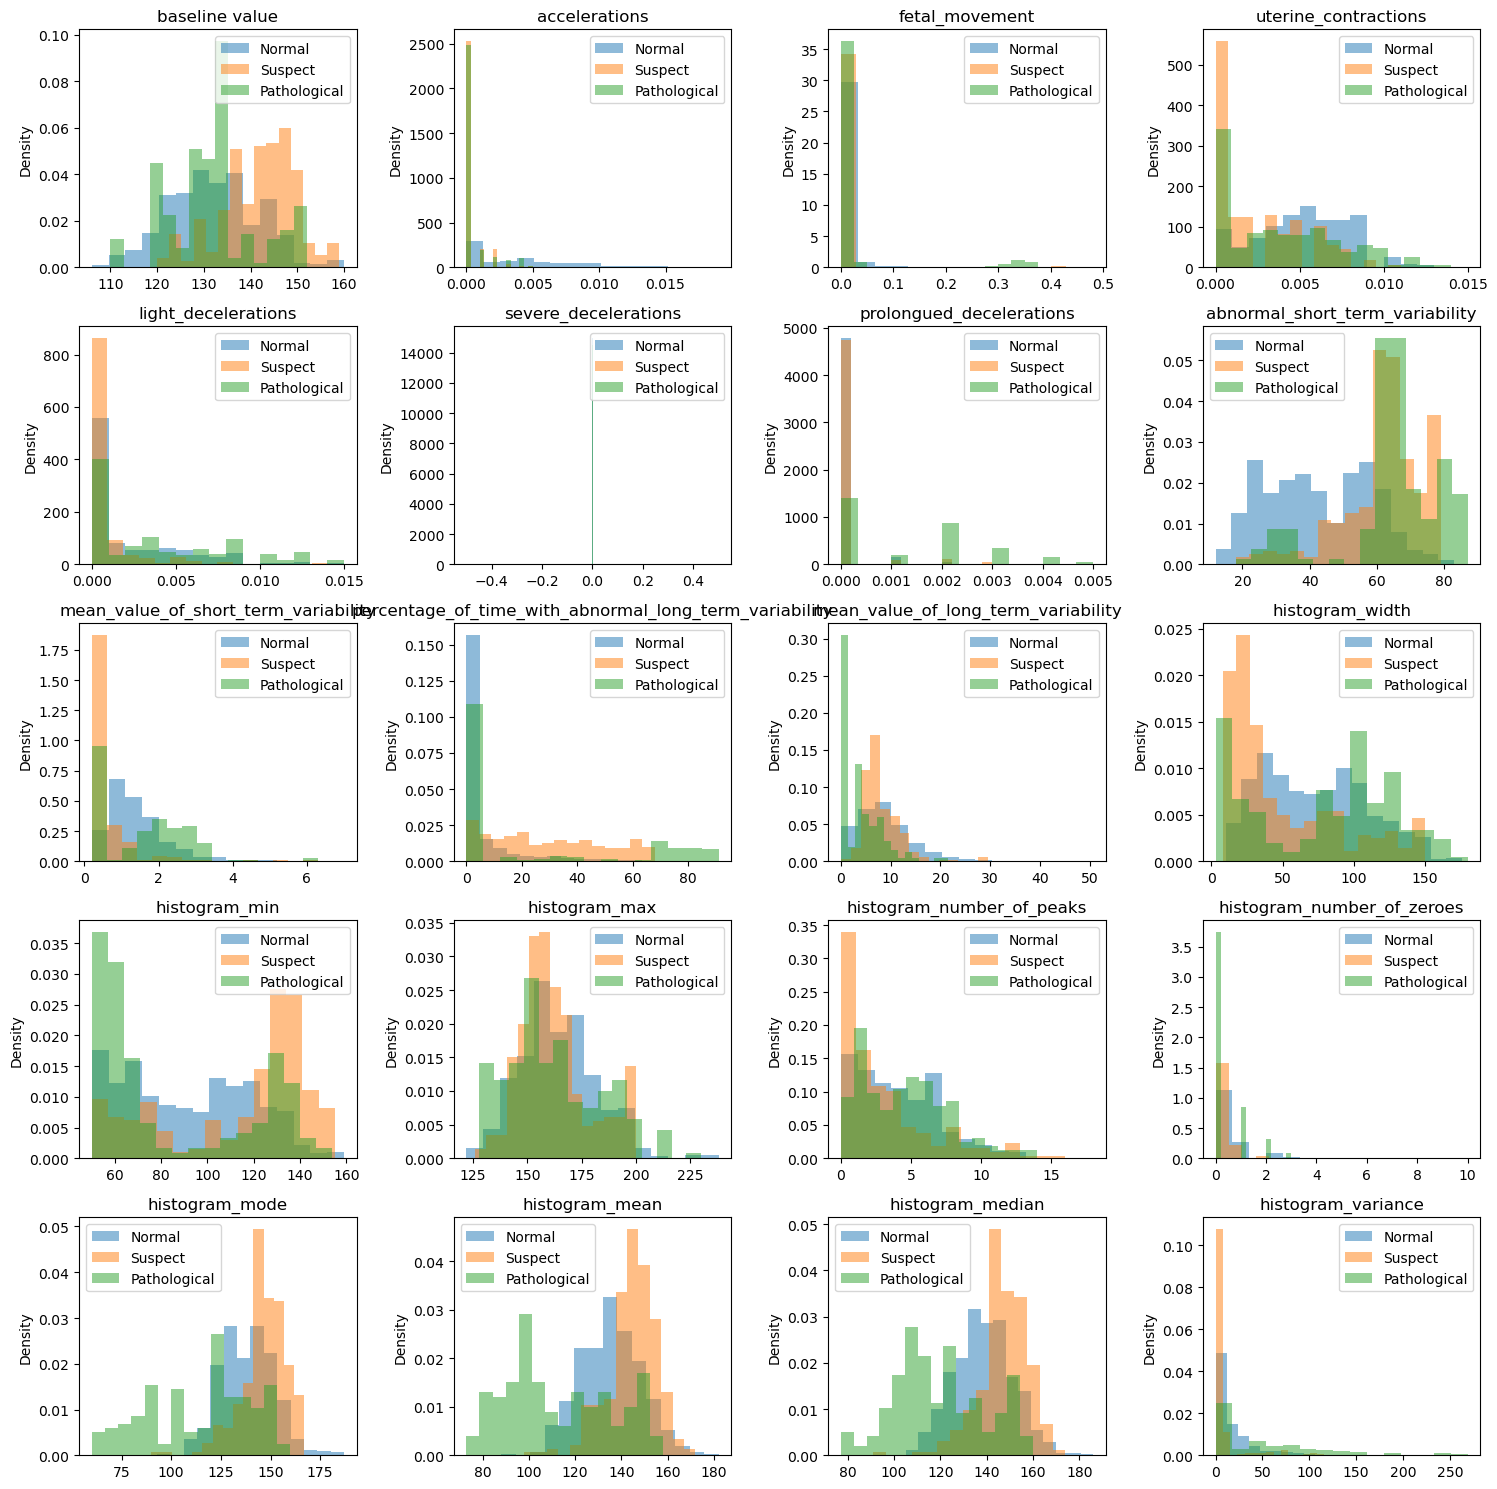

In [10]:
# Create subplots
fig, axes = plt.subplots(5, 4, figsize=(15, 15))
axes = axes.flatten()

# Create the overlayed histograms
for i,column in enumerate(numerical_cols):
    axes[i].hist(normal[column], bins=15, density=1, label="Normal", alpha=0.5)
    axes[i].hist(suspect[column], bins=15, density=1, label="Suspect", alpha=0.5)
    axes[i].hist(pathological[column], bins=15, density=1, label="Pathological", alpha=0.5)
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('Density')
    axes[i].legend()

# Display the plots
plt.tight_layout()  
plt.show()

Now, let's look at the categorical features.

In [11]:
# Function that compares how much of each class belongs to a certain feature
def compare_categorical(df, column_name, selections):
    out = list()

    all_values = df[column_name].dropna().unique()
    for label, selection in selections.items():        
        df_0 = df[selection].dropna(subset=[column_name])
        total = len(df_0)
        out.append([label] + [np.sum(df_0[column_name] == val) / total if total > 0 else 0 for val in all_values])
        
    return out, all_values

# Dictionary of class selections 
selection_dict = {"Normal":df["fetal_health"] == "1.0",
                 "Suspect":df["fetal_health"] == "2.0",
                 "Pathological":df["fetal_health"] == "3.0"}

# Categorical features
categorical_col = ['histogram_tendency', 'fetal_health']

Note that around 27.8% of pathological cases had a negative histogram trend, compared to <7% of normal and suspect cases. The feature could also be useful for training later on.

In [12]:
# Create a table for each feature
for feature in categorical_col:
    print(feature)
    results = compare_categorical(df, feature, selection_dict)
    display(HTML(tabulate.tabulate(results[0], tablefmt='html', headers=results[1])))

histogram_tendency


,1.0,0.0,-1.0
Normal,0.403021,0.535952,0.0610272
Suspect,0.484746,0.464407,0.0508475
Pathological,0.204545,0.517045,0.278409


fetal_health


,2.0,1.0,3.0
Normal,0,1,0
Suspect,1,0,0
Pathological,0,0,1


# Data Cleaning and Preparation

Now to prepare the dataset for machine learning training. There are no missing values and I'm going to choose to leave the outliers alone since we don't want to cut down on the little data we have, and their prescence could be important for separating the pathological or suspect classes. All that will be done is one-hot encoding 'histogram_tendency' and creating a processed CSV file.

In [13]:
# Initialize the encoder
one = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder and transform the categorical column
one.fit(df[['histogram_tendency']])  
encoded_arr = one.transform(df[['histogram_tendency']])

# Convert the result into a DataFrame
encoded = pd.DataFrame(encoded_arr,columns=one.get_feature_names_out(['histogram_tendency']),index=df.index)

# Combine with original dataframe (excluding the original column)
df_encoded = pd.concat([df.drop(columns='histogram_tendency'), encoded], axis=1)

# Move class label to the end of the dataset
labels = df_encoded.pop('fetal_health')
df_encoded['fetal_health'] = labels

In [14]:
df_encoded.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency_-1.0,histogram_tendency_0.0,histogram_tendency_1.0,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,2.0,0.0,120.0,137.0,121.0,73.0,0.0,0.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,11.0,0.0,137.0,134.0,137.0,13.0,0.0,0.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,9.0,0.0,137.0,136.0,138.0,11.0,0.0,0.0,1.0,1.0


In [15]:
df_encoded.to_csv("df_encoded.csv", index=False)